In [1]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50


Using TensorFlow backend.


In [2]:
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)
    data = data.values
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)
    df=pd.DataFrame(data).head(len(next_day_open_values))
    df[5]=next_day_open_values
    df[6]=1-df[5]/df[0]
    data=df[[0,1,2,3,4,5]].values
    next_day_open_values=df[6].values #ERROR
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(np.expand_dims(next_day_open_values, -1))
    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [3]:
f='mcd_intraday.csv'
# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset(f)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)

(1694, 50, 5)
(189, 50, 5)
Train on 1524 samples, validate on 170 samples
Epoch 1/50
1524/1524 [==============================] - 2s 1ms/step - loss: 0.0203 - val_loss: 4.3922e-04
Epoch 2/50
1524/1524 [==============================] - 1s 588us/step - loss: 0.0027 - val_loss: 4.3199e-04
Epoch 3/50
1524/1524 [==============================] - 1s 617us/step - loss: 0.0023 - val_loss: 2.6628e-04
Epoch 4/50
1524/1524 [==============================] - 1s 666us/step - loss: 0.0019 - val_loss: 3.8158e-04
Epoch 5/50
1524/1524 [==============================] - 1s 591us/step - loss: 0.0017 - val_loss: 1.9516e-04
Epoch 6/50
1524/1524 [==============================] - 1s 593us/step - loss: 0.0017 - val_loss: 1.6260e-04
Epoch 7/50
1524/1524 [==============================] - 1s 757us/step - loss: 0.0014 - val_loss: 1.6580e-04
Epoch 8/50
1524/1524 [==============================] - 1s 763us/step - loss: 0.0013 - val_loss: 2.0133e-04
Epoch 9/50
1524/1524 [==============================] - 1s 793us

In [4]:
unscaled_y_test.shape

(189,)

In [5]:
unscaled_y_test

array([-9.25126434e-04, -8.32767874e-04, -6.00835494e-04, -3.87948315e-04,
        0.00000000e+00,  1.84968247e-04,  3.08289916e-05,  2.52774353e-04,
       -6.16560824e-05,  8.69297164e-05,  6.16484804e-05,  9.06009245e-05,
        6.16370809e-05,  6.65677191e-05,  4.08612793e-04,  3.08185404e-04,
        1.35559800e-03,  1.72509396e-03,  1.45281762e-03,  3.08213900e-05,
        8.32126237e-04,  9.55404198e-04,  1.44222769e-03,  1.23274162e-03,
        1.10953584e-03,  7.39872988e-04,  1.07871540e-03,  7.70558501e-04,
        9.24613203e-04,  1.53495253e-03,  1.90514370e-03,  1.25413575e-03,
        1.76191357e-03,  1.44908688e-03,  5.54596993e-04,  3.21527564e-04,
        3.08024026e-04,  1.23220997e-04, -1.23239979e-04, -4.88646517e-04,
       -8.78111905e-04, -1.29405965e-03, -1.26344335e-03, -1.32523808e-03,
       -8.62759598e-04, -1.07241250e-03, -1.23266564e-03, -8.01084545e-04,
       -8.62759598e-04, -5.54562820e-04, -6.77799002e-04, -6.47169404e-04,
       -1.01723128e-03, -

In [6]:
y_test_predicted.shape

(189, 1)

In [7]:
y_test_predicted

array([[-2.5190210e-03],
       [-2.5116531e-03],
       [-2.5208013e-03],
       [-2.5488974e-03],
       [-2.6292796e-03],
       [-2.7192042e-03],
       [-2.7831164e-03],
       [-2.8172699e-03],
       [-2.8168415e-03],
       [-2.8226560e-03],
       [-2.7881449e-03],
       [-2.7572836e-03],
       [-3.1082637e-03],
       [-2.9353250e-03],
       [-2.8144647e-03],
       [-2.7789862e-03],
       [-2.7478570e-03],
       [-2.8284686e-03],
       [-2.9792972e-03],
       [-3.0845175e-03],
       [-3.0698599e-03],
       [-3.0170262e-03],
       [-3.0500349e-03],
       [-3.1157229e-03],
       [-3.1891116e-03],
       [-3.2643646e-03],
       [-3.2532045e-03],
       [-3.2652079e-03],
       [-3.2227491e-03],
       [-3.1989696e-03],
       [-3.2227251e-03],
       [-3.4267039e-03],
       [-3.5721187e-03],
       [-3.6087267e-03],
       [-3.6099090e-03],
       [-3.5453304e-03],
       [-3.1767902e-03],
       [-3.1928862e-03],
       [-2.8304718e-03],
       [-2.5960745e-03],


In [11]:
assert unscaled_y_test.shape[0]== y_test_predicted.shape[0]
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

0.056111218661660585


In [12]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')

<Figure size 2200x1500 with 1 Axes>

In [13]:
y=unscaled_y_test[start:end]
x=y_test_predicted[start:end]

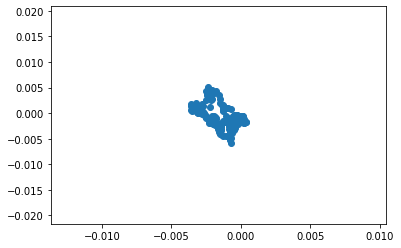

In [14]:
plt.scatter(x,y)
plt.show()

In [15]:
from sklearn.metrics import r2_score
r2_score(x,y)

-6.7010755484645355

In [16]:
len(y)

188

In [17]:
y_normaliser

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
unscaled_y_test

array([-9.25126434e-04, -8.32767874e-04, -6.00835494e-04, -3.87948315e-04,
        0.00000000e+00,  1.84968247e-04,  3.08289916e-05,  2.52774353e-04,
       -6.16560824e-05,  8.69297164e-05,  6.16484804e-05,  9.06009245e-05,
        6.16370809e-05,  6.65677191e-05,  4.08612793e-04,  3.08185404e-04,
        1.35559800e-03,  1.72509396e-03,  1.45281762e-03,  3.08213900e-05,
        8.32126237e-04,  9.55404198e-04,  1.44222769e-03,  1.23274162e-03,
        1.10953584e-03,  7.39872988e-04,  1.07871540e-03,  7.70558501e-04,
        9.24613203e-04,  1.53495253e-03,  1.90514370e-03,  1.25413575e-03,
        1.76191357e-03,  1.44908688e-03,  5.54596993e-04,  3.21527564e-04,
        3.08024026e-04,  1.23220997e-04, -1.23239979e-04, -4.88646517e-04,
       -8.78111905e-04, -1.29405965e-03, -1.26344335e-03, -1.32523808e-03,
       -8.62759598e-04, -1.07241250e-03, -1.23266564e-03, -8.01084545e-04,
       -8.62759598e-04, -5.54562820e-04, -6.77799002e-04, -6.47169404e-04,
       -1.01723128e-03, -

In [19]:
y_test

array([[0.20639835],
       [0.19711042],
       [0.18885449],
       [0.18738906],
       [0.17956656],
       [0.17956656],
       [0.18369453],
       [0.17936017],
       [0.1878225 ],
       [0.18491228],
       [0.1878225 ],
       [0.19510836],
       [0.19401445],
       [0.19401445],
       [0.18575851],
       [0.18575851],
       [0.16099071],
       [0.15273478],
       [0.16088751],
       [0.19195046],
       [0.16718266],
       [0.1630547 ],
       [0.1496388 ],
       [0.15479876],
       [0.15686275],
       [0.16099071],
       [0.15789474],
       [0.16615067],
       [0.1630547 ],
       [0.14055728],
       [0.11168215],
       [0.14241486],
       [0.13089783],
       [0.14757482],
       [0.18575851],
       [0.20800826],
       [0.20330237],
       [0.20639835],
       [0.20949432],
       [0.22173375],
       [0.23374613],
       [0.24767802],
       [0.24148607],
       [0.23942208],
       [0.23116615],
       [0.23426213],
       [0.23942208],
       [0.231

In [ ]:
import pandas as pd
df=pd.read_csv(f)

In [ ]:
df